<a href="https://colab.research.google.com/github/govardhan-06/DL-models/blob/main/FER_2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.makedirs("data",exist_ok=True)
os.makedirs("data/fer2013",exist_ok=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import shutil
import os

# Source folder path in Google Drive
src_folder = '/content/drive/MyDrive/AIML'

# Destination folder path in Colab
dest_folder = '/content/data/fer2013'

# Create destination folder if it doesn't exist
os.makedirs(dest_folder, exist_ok=True)

# Copy the entire folder
shutil.copytree(src_folder, dest_folder, dirs_exist_ok=True)

'/content/data/fer2013'

###1. Data Ingestion phase

In [4]:
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision.datasets

train_set= torchvision.datasets.FER2013(
    root="data",
    split="train",
    transform=ToTensor(),
    target_transform=None,
)

test_set= torchvision.datasets.FER2013(
    root="data",
    split="test",
    transform=ToTensor(),
    target_transform=None,
)

In [6]:
print(f"Length of train set: {len(train_set)}")
print(f"Length of test set: {len(test_set)}")

Length of train set: 28709
Length of test set: 7178


In [9]:
print(train_set)
print("\n")
print(test_set)

Dataset FER2013
    Number of datapoints: 28709
    Root location: data
    split=train
    StandardTransform
Transform: ToTensor()


Dataset FER2013
    Number of datapoints: 7178
    Root location: data
    split=test
    StandardTransform
Transform: ToTensor()


In [28]:
import pandas as pd
df=pd.read_csv("data/fer2013/train.csv")
##Does not having a labels for different emotions inside the dataset

In [29]:
print("Sample data:")
print(train_set.__getitem__(10))

Sample data:
(tensor([[[0.1176, 0.0941, 0.0824,  ..., 0.1451, 0.1725, 0.1451],
         [0.1216, 0.0863, 0.0824,  ..., 0.1451, 0.1373, 0.1608],
         [0.1059, 0.0863, 0.0745,  ..., 0.1294, 0.1333, 0.1569],
         ...,
         [0.1137, 0.1137, 0.1020,  ..., 0.4627, 0.5176, 0.5804],
         [0.1176, 0.1176, 0.1059,  ..., 0.6039, 0.6235, 0.6510],
         [0.1255, 0.1137, 0.1098,  ..., 0.6745, 0.6784, 0.6784]]]), 0)


In [32]:
##Mapping emotion label to the respective emotion terms
emotion_label_map = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [33]:
df['Emotions']= df['emotion'].map(emotion_label_map)
df.head()

,emotion,pixels,Emotions
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral


### Checking the input and output

In [37]:
image, label = train_set.__getitem__(0)
print(f"Image shape: {image.shape} -> [colour_channels,height,width]")
print(f"Image label: {label}")

Image shape: torch.Size([1, 48, 48]) -> [colour_channels,height,width]
Image label: 0


### Visualizing the image

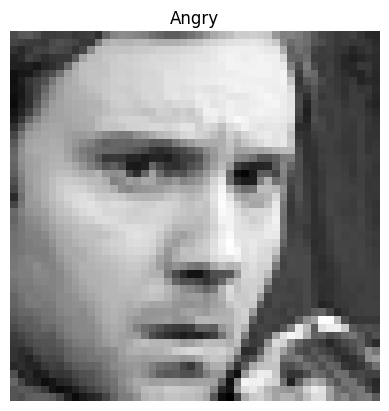

In [48]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze(), cmap="gray")
plt.title(emotion_label_map[label])
plt.axis("off")
plt.show()

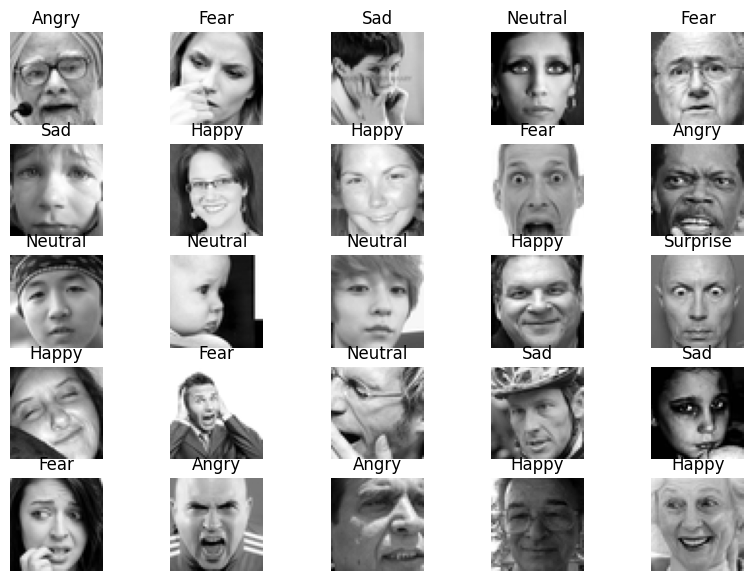

In [54]:
torch.manual_seed(42)
rows,cols=5,5
plt.figure(figsize=(10,7))
for i in range(1,rows*cols+1):
  img,label=train_set[i]
  plt.subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(emotion_label_map[label])
  plt.axis('off')

### Turning image data to batches

In [57]:
from torch.utils.data import DataLoader

BATCH_SIZE=32

train_dataloader= DataLoader(train_set,BATCH_SIZE,shuffle=True)
test_dataloader= DataLoader(test_set,BATCH_SIZE,shuffle=True)

In [58]:
print(f"Length of train dataloader: {len(train_dataloader)} batches of batch size : {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of batch size : {BATCH_SIZE}")

Length of train dataloader: 898 batches of batch size : 32
Length of test dataloader: 225 batches of batch size : 32


### Inspection image inside the batch

In [61]:
train_batch_image, train_batch_label=next(iter(train_dataloader))
print(f"Image batch shape: {train_batch_image.shape} -> [batch_size,colour_channels,height,width]")
print(f"Label batch shape: {train_batch_label.shape} -> [batch_size]")

Image batch shape: torch.Size([32, 1, 48, 48]) -> [batch_size,colour_channels,height,width]
Label batch shape: torch.Size([32]) -> [batch_size]


First Batch


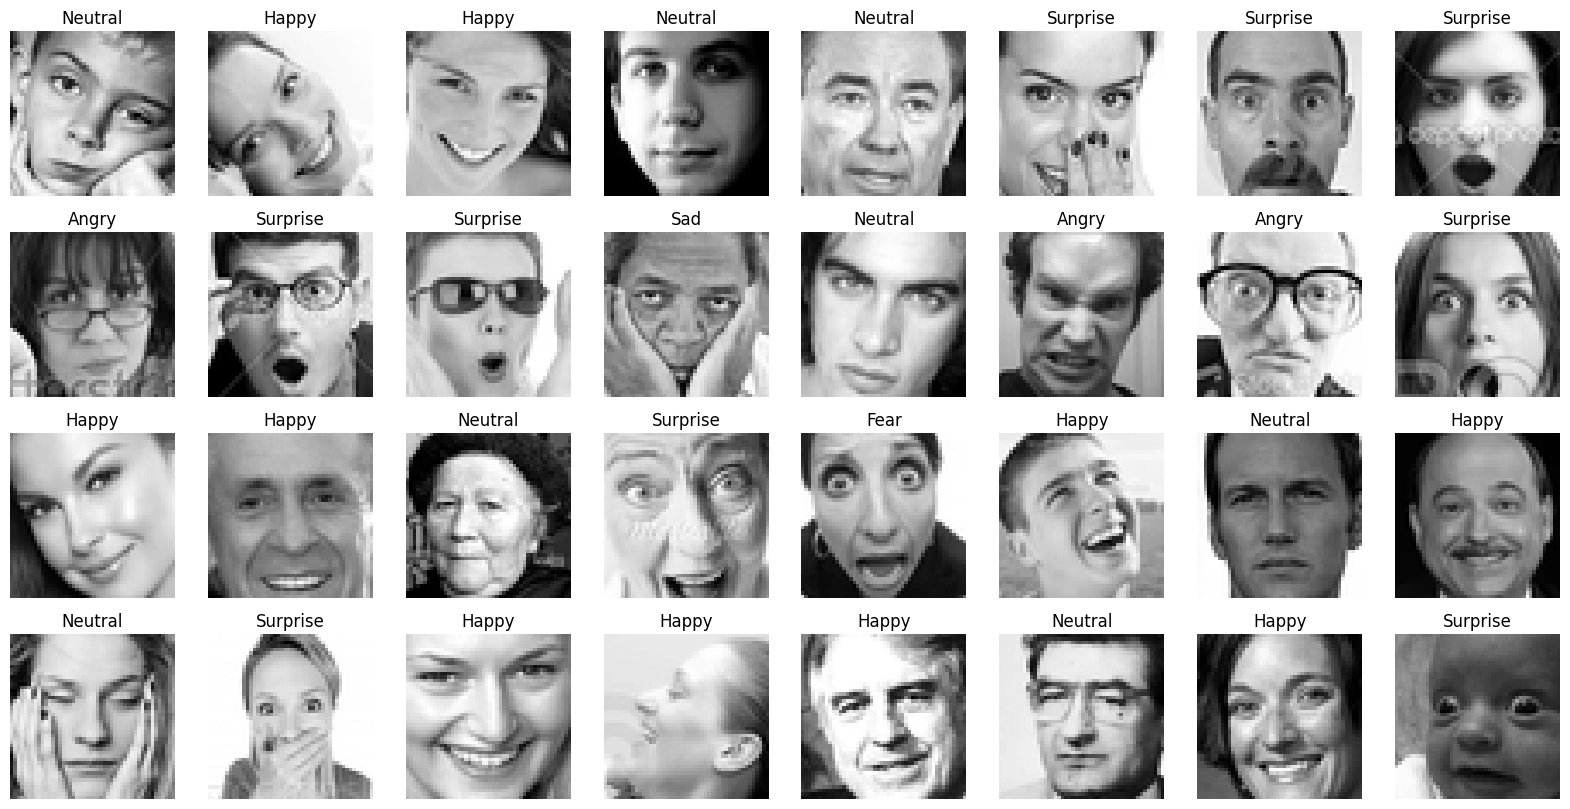

In [72]:
plt.figure(figsize=(20,10))
print("First Batch")
for i in range(0,BATCH_SIZE):
  plt.subplot(4,8,i+1)
  plt.imshow(train_batch_image[i].squeeze(),cmap="gray")
  plt.title(emotion_label_map[train_batch_label[i].item()])
  plt.axis('off')

### Device agnostic code

In [71]:
device='cudea' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Model Training